<a href="https://colab.research.google.com/github/atstuyuki/mediapipe/blob/main/mediapipe_throw_create_releasedetect_20221119.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

mediapipeで検出された投球動作の座標、角度、体幹面積等のデータ(CSV)から、リリース期（前足設置～ボールスロー）であるかどうかを判別するモデルをscikit learnにて作成・保存する

In [1]:
#cat_boost をインストール
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [3]:
#ライブラリのインポート

# data analysis and wranglinimport seaborn as sns

import math
import pandas as pd
import numpy as np
import random as rnd
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler #正規化（最小0,最大1となるように変換）
from sklearn.preprocessing import StandardScaler #標準化（平均0,分散1となるように変換）
from sklearn.preprocessing import RobustScaler #中央値0,四分位範囲1となるように変換(外れ値の影響を抑える)
from sklearn.preprocessing import LabelEncoder #カテゴリ変数の置換
from sklearn.pipeline import Pipeline #パイプライン（変換器と推定器を結合）
from sklearn.model_selection import train_test_split
#splitting data : train_data 80%,test_data 20%
#X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.20, random_state=1)

# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LinearRegression #線形回帰
from sklearn.linear_model import Lasso, LassoCV #Lasso ,LassoCV(内部チューニング)
from sklearn.linear_model import Ridge, RidgeCV #Ridge ,RidgeCV(内部チューニング) 
from sklearn.linear_model import ElasticNet ,ElasticNetCV #RElasticNet , ElasticNetCV(内部チューニング) 
from sklearn.linear_model import LogisticRegression #ロジスティック回帰
from sklearn.kernel_ridge import KernelRidge #カーネルリッジ回帰
from sklearn.svm import SVC, LinearSVC #SVM
from sklearn.decomposition import PCA #PCA(主成分分析）
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA #LDA(線形判別分析)
from sklearn.ensemble import RandomForestClassifier #ランダムフォレスト
from sklearn.ensemble import RandomForestRegressor #ランダムフォレスト回帰
from sklearn.ensemble import GradientBoostingRegressor #勾配ブースティング回帰
from sklearn.neighbors import KNeighborsClassifier #k近傍法
from sklearn.cluster import KMeans #k-means法 (非階層的クラスタリング(クラスター分析))
from sklearn.cluster import AgglomerativeClustering #階層的クラスタリング(クラスター分析)
from sklearn.cluster import DBSCAN #DBSCAN(クラスター分析)
from sklearn.naive_bayes import GaussianNB #ナイーブベイズ（正規分布ver)
from sklearn.linear_model import Perceptron #パーセプトロン
from sklearn.linear_model import SGDClassifier #確率的勾配降下
from sklearn.tree import DecisionTreeClassifier #決定木
from sklearn.tree import DecisionTreeRegressor #決定木回帰
import xgboost as xgb #XGBoost
import lightgbm as lgb #LightGBM
import catboost as cb #catvoost

#model_evaluation & tuning
from sklearn.metrics import r2_score #決定係数R^2
from sklearn.metrics import mean_squared_error #平均二乗誤差MSE 
from sklearn.metrics import confusion_matrix #混同行列
from sklearn.metrics import accuracy_score #正解率
from sklearn.model_selection import KFold #k分割交差検証
from sklearn.model_selection import StratifiedKFold #層化k分割交差検証
from sklearn.model_selection import cross_val_score #交差検証のスコア
from sklearn.model_selection import learning_curve #学習曲線
from sklearn.model_selection import validation_curve #検証曲線
from sklearn.model_selection import GridSearchCV #グリッドサーチ

#ignore warnings which are not unrelated to work
#実行に影響がない警告の非表示
import warnings
warnings.filterwarnings('ignore')

In [4]:
#手元のデータをgoogle colabにupload

from google.colab import files
import os
uploaded = files.upload()
#uploadedは辞書型なのでファイル名を取り出し、絶対パスを取得してfullpathという変数を当てる
for k in uploaded.keys():
  print('file name:',k)
fullpath=os.path.abspath(k)
print('fullpath:',fullpath)

Saving combined_results_20221119.csv to combined_results_20221119.csv
file name: combined_results_20221119.csv
fullpath: /content/combined_results_20221119.csv


In [5]:
#dataのインポート  \を　/に置き換えfullpathを代入　csvを’,'で区切る 
#文字認識異常が出た時は　encoding='UTF-8'や’shift_jis'にする　もともとのCSVファイルの文字形式を確認する
#もともとのCSVで数値がintやfloatではなくstring等の事があるので、良くチェックしておく
#https://insilico-notebook.com/python-unicodedecodeerror/
df=pd.read_csv(fullpath,sep=',',encoding='UTF-8')

In [6]:
df.head()#データの最初の5行の表示

,IsRelease,rt_elbow_angle,rt_shoulder_angle,rt_shoulder_Abduction,rt_hip_angle,rt_knee_angle,lt_elbow_angle,lt_shoulder_angle,lt_shoulder_Abduction,lt_hip_angle,lt_knee_angle,rtwrist_ratio,ltwrist_ratio,rttrunksize,lttrunksuze
0,0,148.477607,151.889151,109.181674,177.281764,173.365278,137.701626,15.199159,92.446587,56.349742,58.762873,0.607665,0.579833,0.010419,0.009875
1,0,149.183080,145.779809,108.711564,178.307922,174.057846,137.084325,20.157982,91.459586,55.873258,58.499983,0.553531,0.598956,0.010881,0.010426
2,0,145.383257,168.049547,99.901909,179.846564,174.738406,102.409958,39.509625,70.668734,57.735298,60.241240,0.470195,0.637718,0.013726,0.013695
3,0,99.884619,178.372393,69.178449,171.432900,170.720567,139.758954,66.881051,3.122431,63.005475,61.149810,0.773089,0.488212,0.022672,0.021018
4,0,108.380036,178.235521,52.390886,176.319665,172.089317,89.837850,5.028491,40.758086,65.608110,59.000899,0.519163,0.783621,0.015553,0.014446


In [7]:
#dfの型の確認　object型等は変更する必要がある
df.dtypes

IsRelease                  int64
rt_elbow_angle           float64
rt_shoulder_angle        float64
rt_shoulder_Abduction    float64
rt_hip_angle             float64
rt_knee_angle            float64
lt_elbow_angle           float64
lt_shoulder_angle        float64
lt_shoulder_Abduction    float64
lt_hip_angle             float64
lt_knee_angle            float64
rtwrist_ratio            float64
ltwrist_ratio            float64
rttrunksize              float64
lttrunksuze              float64
dtype: object

In [ ]:
#今回の解析に不要な列をdrop
#df=df.drop(['Unnamed: 8','Unnamed: 9','Unnamed: 10','Unnamed: 11','Unnamed: 12','Unnamed: 13'],axis='columns') 

In [8]:
#カテゴリ変数をone hot enchoding (drop_first=Trueならダミーエンコーディングなので1次元削減)
df= pd.get_dummies(df,drop_first=True) 
df.dtypes

IsRelease                  int64
rt_elbow_angle           float64
rt_shoulder_angle        float64
rt_shoulder_Abduction    float64
rt_hip_angle             float64
rt_knee_angle            float64
lt_elbow_angle           float64
lt_shoulder_angle        float64
lt_shoulder_Abduction    float64
lt_hip_angle             float64
lt_knee_angle            float64
rtwrist_ratio            float64
ltwrist_ratio            float64
rttrunksize              float64
lttrunksuze              float64
dtype: object

In [9]:
#dfの欠損値の確認
df.isnull().sum()

IsRelease                0
rt_elbow_angle           0
rt_shoulder_angle        0
rt_shoulder_Abduction    0
rt_hip_angle             0
rt_knee_angle            0
lt_elbow_angle           0
lt_shoulder_angle        0
lt_shoulder_Abduction    0
lt_hip_angle             0
lt_knee_angle            0
rtwrist_ratio            0
ltwrist_ratio            0
rttrunksize              0
lttrunksuze              0
dtype: int64

In [10]:
# データフレームの統計量記述
df.describe()

,IsRelease,rt_elbow_angle,rt_shoulder_angle,rt_shoulder_Abduction,rt_hip_angle,rt_knee_angle,lt_elbow_angle,lt_shoulder_angle,lt_shoulder_Abduction,lt_hip_angle,lt_knee_angle,rtwrist_ratio,ltwrist_ratio,rttrunksize,lttrunksuze
count,7211.000000,7211.000000,7211.000000,7211.000000,7211.000000,7211.000000,7211.000000,7211.000000,7211.000000,7211.000000,7211.000000,7211.000000,7211.000000,7211.000000,7211.000000
mean,0.057828,117.012730,105.756522,35.212321,150.462358,142.616644,113.493318,97.989524,28.767543,143.044949,137.934329,0.985259,0.963208,0.047598,0.047738
std,0.233435,49.494340,42.360071,31.761491,27.723943,38.075273,50.298237,41.612208,26.691613,30.209001,40.168427,0.440140,0.423541,0.037106,0.036970
min,0.000000,0.035591,0.053249,0.013469,28.221955,5.769761,0.074248,0.048300,0.004434,54.333769,0.410466,0.106196,0.069761,0.000005,0.000022
25%,0.000000,73.545196,78.118874,13.921058,140.103540,130.929250,66.180686,69.110538,11.776404,127.479494,113.779251,0.680881,0.656538,0.020131,0.020272
50%,0.000000,132.996869,109.852281,27.053297,157.643305,159.580596,127.224359,99.838297,22.707578,148.120697,153.836955,0.879279,0.880465,0.038497,0.038156
75%,0.000000,159.769258,138.550518,43.136375,170.462140,169.140360,159.617001,128.297586,35.662232,169.436815,170.547721,1.210657,1.177778,0.066100,0.066979
max,1.000000,179.992410,179.963497,179.841516,179.997762,179.986713,179.996687,179.893912,179.667143,179.986169,179.996167,3.756150,3.756506,0.195489,0.191791


In [11]:
#dataframeの全体的な情報
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7211 entries, 0 to 7210
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   IsRelease              7211 non-null   int64  
 1   rt_elbow_angle         7211 non-null   float64
 2   rt_shoulder_angle      7211 non-null   float64
 3   rt_shoulder_Abduction  7211 non-null   float64
 4   rt_hip_angle           7211 non-null   float64
 5   rt_knee_angle          7211 non-null   float64
 6   lt_elbow_angle         7211 non-null   float64
 7   lt_shoulder_angle      7211 non-null   float64
 8   lt_shoulder_Abduction  7211 non-null   float64
 9   lt_hip_angle           7211 non-null   float64
 10  lt_knee_angle          7211 non-null   float64
 11  rtwrist_ratio          7211 non-null   float64
 12  ltwrist_ratio          7211 non-null   float64
 13  rttrunksize            7211 non-null   float64
 14  lttrunksuze            7211 non-null   float64
dtypes: f

In [12]:
df.columns

Index(['IsRelease', 'rt_elbow_angle', 'rt_shoulder_angle',
       'rt_shoulder_Abduction', 'rt_hip_angle', 'rt_knee_angle',
       'lt_elbow_angle', 'lt_shoulder_angle', 'lt_shoulder_Abduction',
       'lt_hip_angle', 'lt_knee_angle', 'rtwrist_ratio', 'ltwrist_ratio',
       'rttrunksize', 'lttrunksuze'],
      dtype='object')

In [13]:
"""#dataframeの列の並べ替え 目的変数であるRetearを最後の列に入れ替える
new_columns=['stump type', 'Age', 'DM', 'Hyperlipidemia', 'Tear_size', 'Goutallier',
       'Gender_M','Retear']
df=df[new_columns]"""

KeyError: ignored

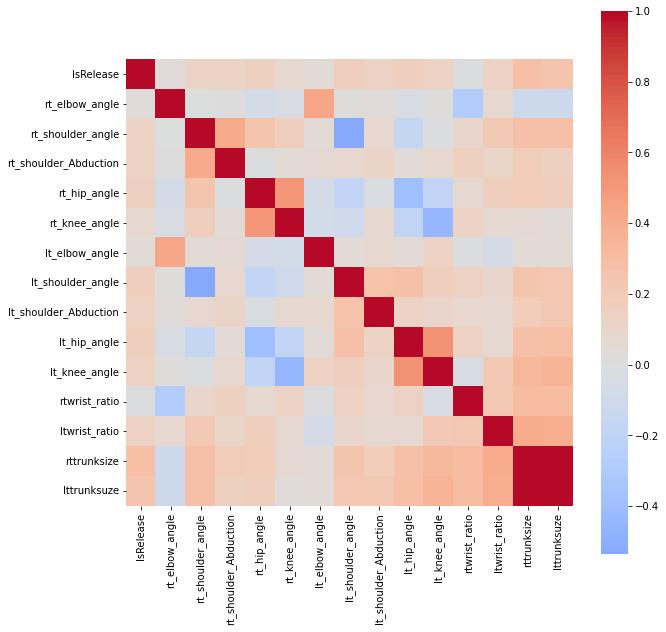

In [14]:
#dfでの相関係数のheatmap 白黒表示であればcmap='binary'とする
#赤色が正の相関を示す
plt.figure(figsize=(10,10))
cmap=sns.color_palette('coolwarm',200)
sns.heatmap(df.corr(),square=True,annot=False,cmap=cmap,center=0)

In [15]:
#Pandasで目的変数別に色分けしたヒストグラムを作成する
#関数の指定
#http://own-search-and-study.xyz/2018/02/27/pandas%e3%81%a7%e7%9b%ae%e7%9a%84%e5%a4%89%e6%95%b0%e5%88%a5%e3%81%ab%e8%89%b2%e5%88%86%e3%81%91%e3%81%97%e3%81%9f%e3%83%92%e3%82%b9%e3%83%88%e3%82%b0%e3%83%a9%e3%83%a0%e3%82%92%e4%bd%9c%e6%88%90/
import pandas as pd
 
def targethist(df, target, save=False, kind='hist', **kwards):
     
    columns = df.columns[df.columns != target]
    pdf = df.pivot_table(index=df.index, columns=target)
     
    for column in columns:
         
        ax = pdf.loc[:, column].plot(kind=kind, title=column, **kwards)
         
        if save==True:
            ax.get_figure().savefig(column+".png") 

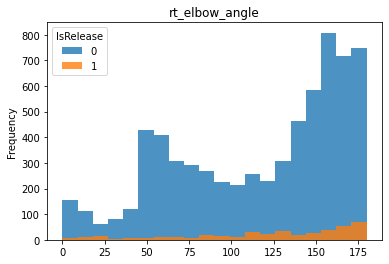

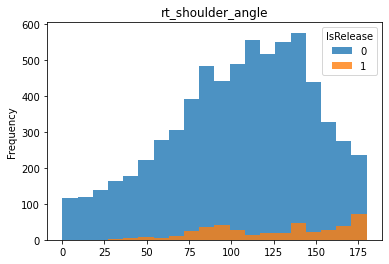

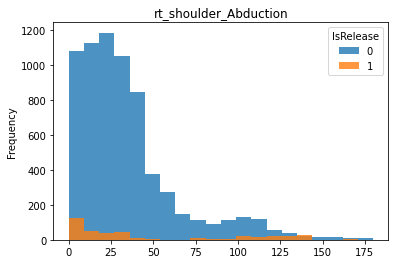

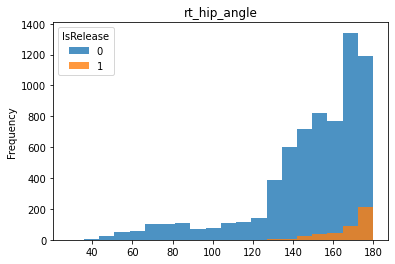

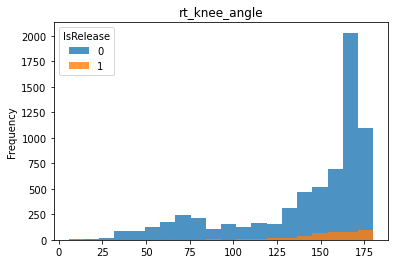

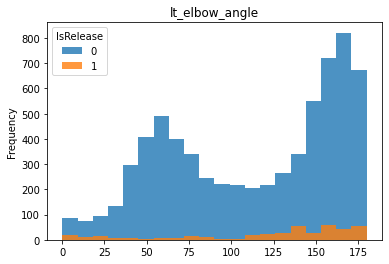

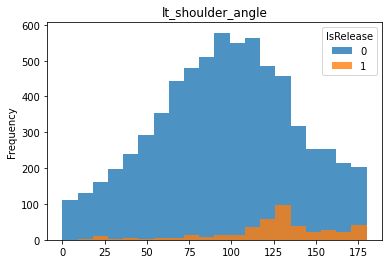

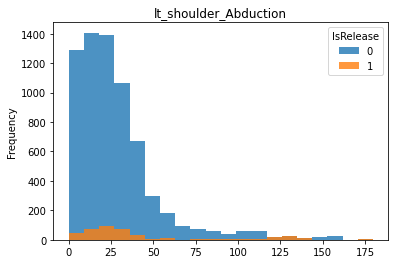

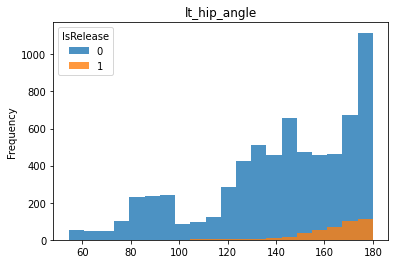

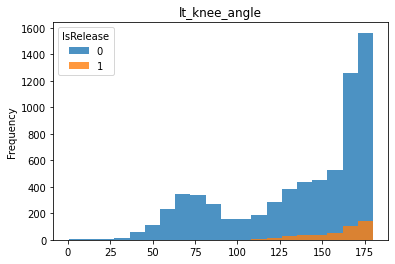

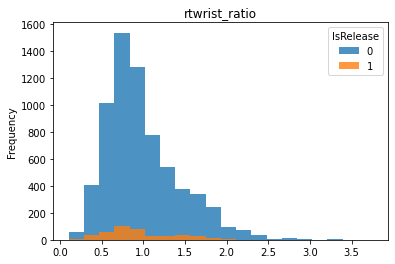

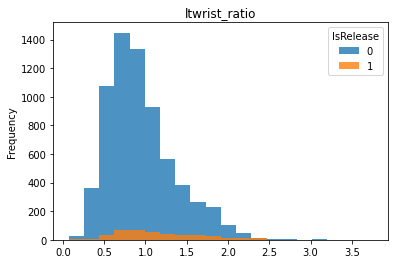

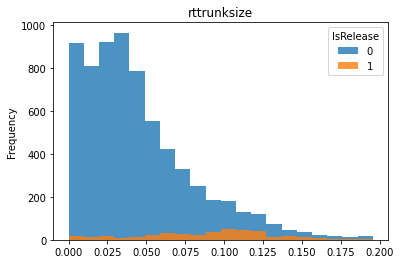

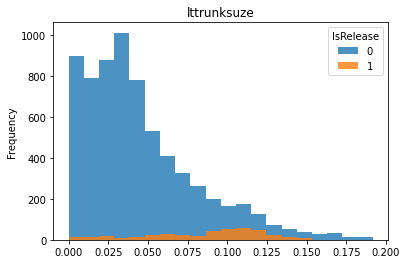

In [16]:
#関数targethistに引数を渡す　
#pandasのplotをラップしている点を活用してパラメータを指定します。
targethist(df,target='IsRelease', bins=20, alpha=0.8)

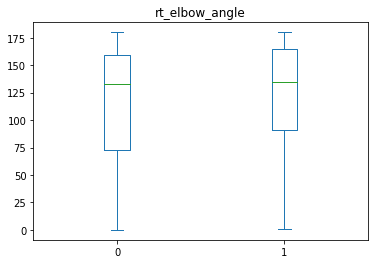

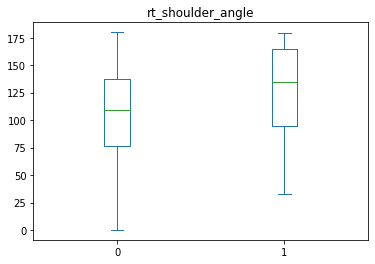

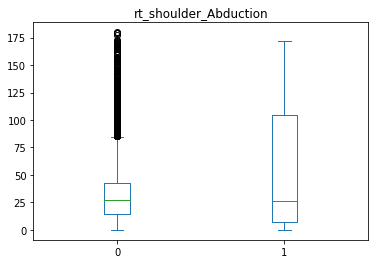

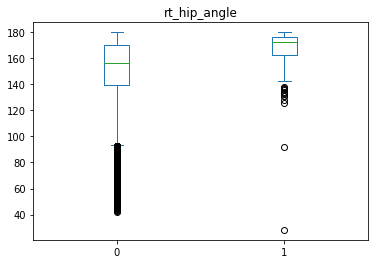

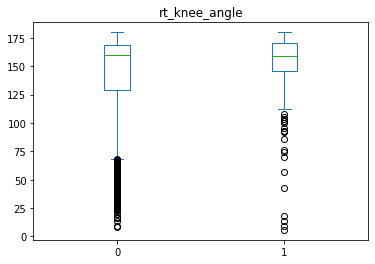

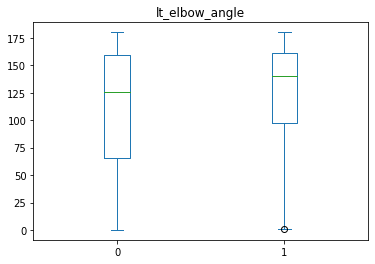

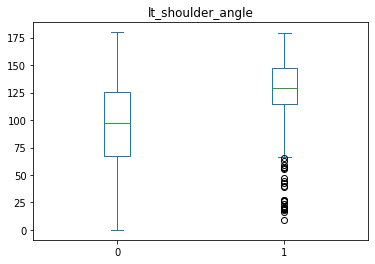

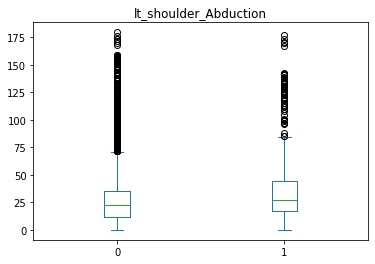

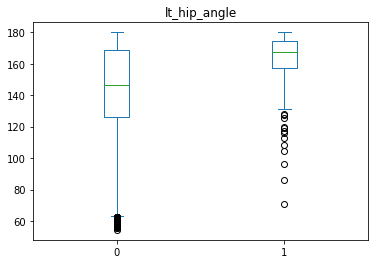

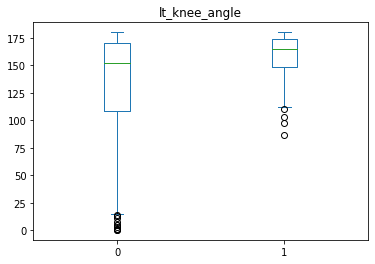

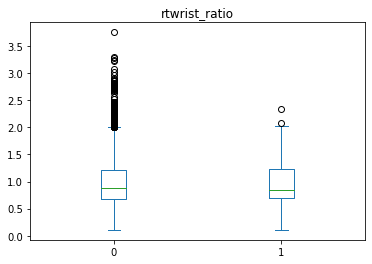

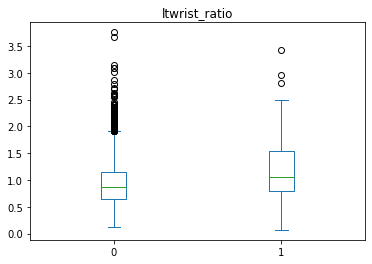

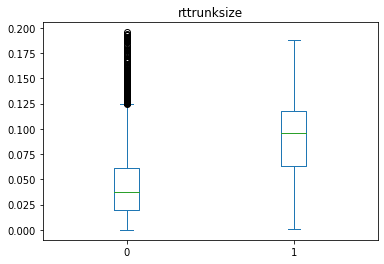

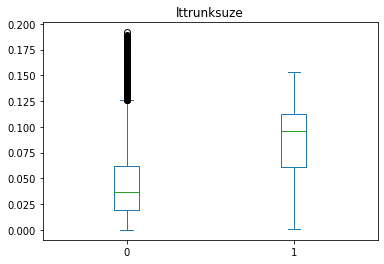

In [17]:
#IsReleaseの有無でのBoxplot
targethist(df, target="IsRelease", kind='box')

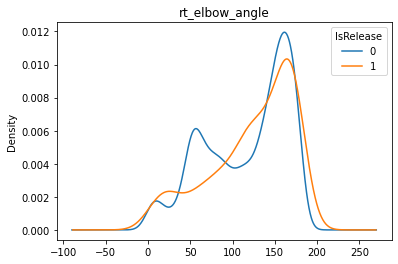

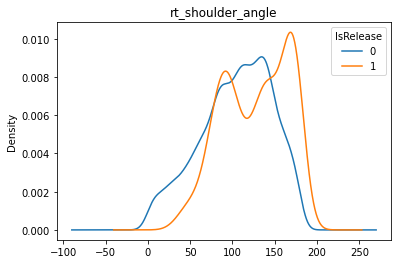

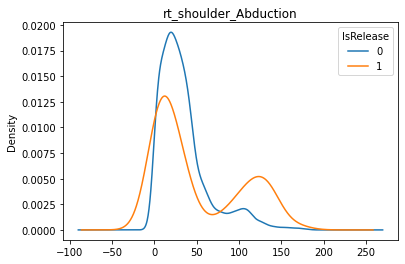

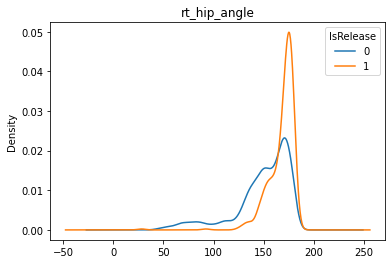

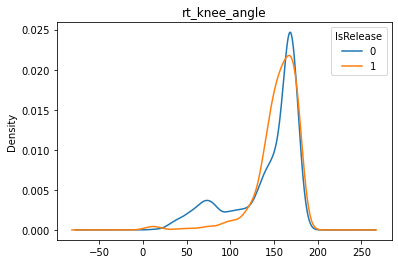

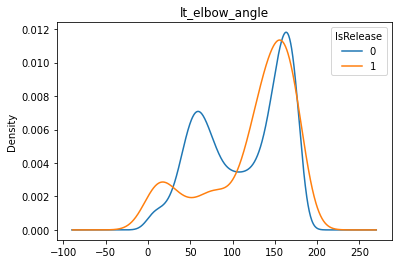

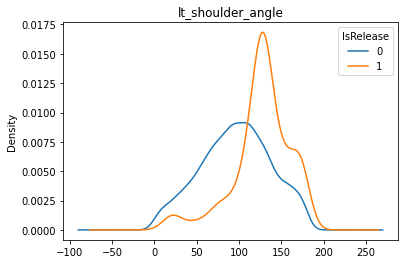

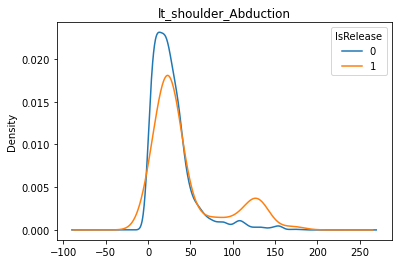

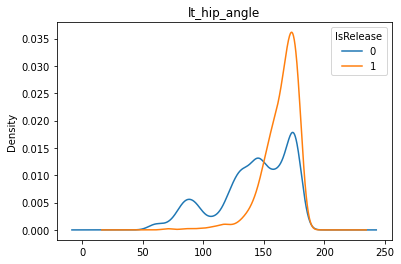

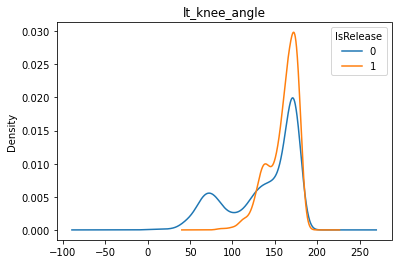

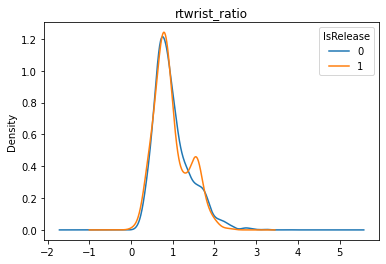

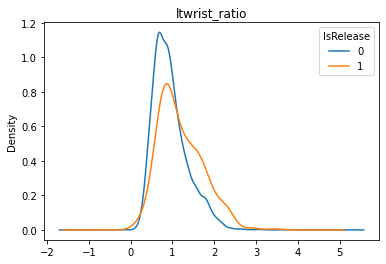

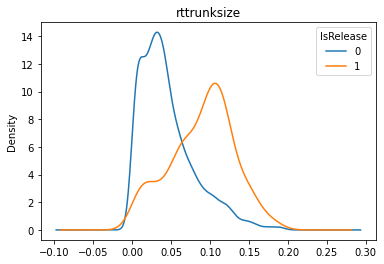

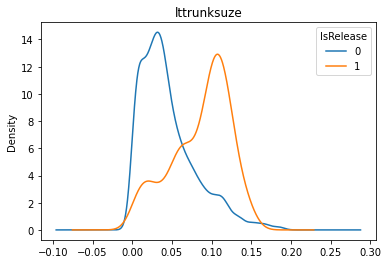

In [18]:
#カーネル密度推定
targethist(df, target="IsRelease", kind='kde')

In [19]:
#isrelease (0=No　１＝YES)の有無でグループ分け
grouped=df.groupby('IsRelease')
#各グループの平均値を表示 省略されないように5データフレームの50列まで表示するように設定
pd.set_option('display.max_columns', 50)
print(grouped.mean())

           rt_elbow_angle  rt_shoulder_angle  rt_shoulder_Abduction  \
IsRelease                                                             
0              116.632926         104.448056              34.268736   
1              123.200712         127.074798              50.585742   

           rt_hip_angle  rt_knee_angle  lt_elbow_angle  lt_shoulder_angle  \
IsRelease                                                                   
0            149.392723     141.902422      112.937367          96.240756   
1            167.889449     154.253152      122.551189         126.481432   

           lt_shoulder_Abduction  lt_hip_angle  lt_knee_angle  rtwrist_ratio  \
IsRelease                                                                      
0                      27.880075    141.772114     136.604485       0.986939   
1                      43.226663    163.782702     159.600890       0.957881   

           ltwrist_ratio  rttrunksize  lttrunksuze  
IsRelease                       

In [20]:
#各グル―プの標準偏差を表示
print(grouped.std())

           rt_elbow_angle  rt_shoulder_angle  rt_shoulder_Abduction  \
IsRelease                                                             
0               49.486438          42.248837              29.858824   
1               49.270802          38.325551              51.713291   

           rt_hip_angle  rt_knee_angle  lt_elbow_angle  lt_shoulder_angle  \
IsRelease                                                                   
0             28.013740      38.627502       50.138425          41.403560   
1             13.549329      24.849089       52.065391          33.983736   

           lt_shoulder_Abduction  lt_hip_angle  lt_knee_angle  rtwrist_ratio  \
IsRelease                                                                      
0                      25.232746     30.446997      40.785739       0.441992   
1                      41.577427     14.882931      17.374929       0.408303   

           ltwrist_ratio  rttrunksize  lttrunksuze  
IsRelease                       

In [21]:
#statsmodelsによる重回帰分析 結果の解釈は　https://tanuhack.com/statsmodels-multiple-lra/#StatsModels
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# get_dummies()カテゴリ変数をone-hot-enchodingで質的データも対応可能
x = pd.get_dummies(df.drop(['IsRelease',],axis='columns') ) # ←もちろん増減可能 今回は目的変数以外すべて採用
y = df['IsRelease']#目的変数の列

# 定数項(y切片)を必要とする線形回帰のモデル式ならば必須
X = sm.add_constant(x)

# 最小二乗法によるモデリング
model = sm.OLS(y,X)
result = model.fit()

# 重回帰分析の結果を表示 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              IsRelease   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     130.9
Date:                Sun, 20 Nov 2022   Prob (F-statistic):               0.00
Time:                        07:37:01   Log-Likelihood:                 1077.4
No. Observations:                7211   AIC:                            -2125.
Df Residuals:                    7196   BIC:                            -2021.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.7557      0.030    -25.165      0.000      -0.815      -0.697
rt_elbow_angle         4.473e-05   6.07e-05      0.737      0.461   -7.43e-05       0.000
rt_shoulder_angle         0.0017      0.000     16.798      0.000       0.002       0.002
rt_shoulder_Abduction    -0.0006      0.000     -5.597      0.000      -0.001      -0.000
rt_hip_angle              0.0019      0.000     15.456      0.000       0.002       0.002
rt_knee_angle            -0.0002   8.88e-05     -1.994      0.046      -0.000   -2.95e-06
lt_elbow_angle         6.773e-05    5.7e-05      1.189      0.234   -4.39e-05       0.000
lt_shoulder_angle         0.0017   9.42e-05     18.256      0.000       0.002       0.002
lt_shoulder_Abduction     0.0005      0.000      4.808      0.000       0.000       0.001
lt_hip_angle              0.0018      0.000     15.410      0.000       0.002       0.002
lt_knee_angle          6.103e-05   9.13e-05      0.669      0.504      -0.000       0.000
rtwrist_ratio            -0.0700      0.007    -10.739      0.000      -0.083      -0.057
ltwrist_ratio            -0.0067      0.007     -0.963      0.336      -0.020       0.007
rttrunksize               7.5765      0.492     15.402      0.000       6.612       8.541
lttrunksuze              -7.2726      0.504    -14.416      0.000      -8.262      -6.284
==============================================================================
Omnibus:                     4053.564   Durbin-Watson:                   0.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28829.052
Skew:                           2.695   Prob(JB):                         0.00
Kurtosis:                      11.179   Cond. No.                     1.04e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# **最初に不均等データの分布を変更せずに、ランダムフォレスト・ロジステック回帰・Adaboost・lightGBMを試す**

In [22]:
#分類するクラスを確認  'isrelease'=0がリリース期以外　１がリリース期
df['IsRelease'].value_counts()

0    6794
1     417
Name: IsRelease, dtype: int64

# **データを訓練データと検証データに分割**

In [23]:
target='IsRelease'

In [24]:
#データセットの分割　正解クラス　説明変数の指定
#訓練データの不要な列を df.drop([],axis='columns')で指定
#テストデータ数が少ないのでtestデータを30%に指定
#stratifyでtrain と　testでの分布を統一
train_x=df.drop([target],axis='columns') 
train_y=df[target]
(train_x,test_x,train_y,test_y)=train_test_split(train_x,train_y,test_size=0.3,random_state=0,stratify=df[target].values)

In [25]:
#データセットの形確認
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(5047, 14)
(2164, 14)
(5047,)
(2164,)


In [26]:
# 訓練データ中のisrelase=1のサンプル数をカウント(train_yの'1'の数値の合計)
#テストデータ中もカウント
positive_count_train =train_y.sum()
positive_count_test=test_y.sum()
print('positive target numbers in train: {}'.format(positive_count_train))
print('positive target numbers in test:{}'.format(positive_count_test))

positive target numbers in train: 292
positive target numbers in test:125


In [27]:
#評価用関数のインポートおよび定義
from sklearn.metrics import recall_score#recall score用の関数インポート
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [28]:
#感度　特異度の関数定義

#感度
def sensitivity1(test_y, pred_y):
    cm = confusion_matrix(test_y,pred_y, labels=[1, 0])
    return cm[0, 0]/ (cm[0,0]+cm[0,1])

#特異度
def specificity1(test_y, pred_y):
    cm = confusion_matrix(test_y, pred_y, labels=[1, 0])
    return cm[1, 1]/ (cm[1,0]+cm[1,1])

# 不均衡データ　ランダムフォレストモデル＋gridSearchによる予測モデル構築

In [29]:
#ランダムフォレストモデルの構築
gridsearch = {'n_estimators': [100,200,300,400],#決定木の数を辞書で渡す
             'max_depth': [4,5,6]}#決定木の数を辞書で渡す
score='recall'#モデルの評価関数を指定 roc_aucからrecallに変更
                 #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                 #　今回は検診で偽陰性をへらしたいのでpercisionを使用
model_rf=GridSearchCV(RandomForestClassifier(),#分類器の指定
                 gridsearch,#グリッドサーチで定義した辞書を渡す
                 cv=5,              #交差検定の回数指定
                 n_jobs= -1, #-1に設定するとコア数で並列実行
                 scoring=score,#モデルの評価関数の指定 今回は異常検知なのでrecall使用
                 verbose=True) #verbose=Trueで実行状況の表示
model_rf.fit(train_x,train_y)#学習の実行 fit関数
pred_y=model_rf.predict(test_x)#予測値の算出
print('不均衡データ　ランダムフォレストモデルの精度')
train_accuracy=model_rf.score(train_x,train_y)#学習データでの精度の算出
print('Train Accuracy:{}'.format(train_accuracy))
test_accuracy=accuracy_score(test_y,pred_y)#テストデータでの精度の算出
print('Test Accuracy:{}'.format(test_accuracy))
recall=recall_score(test_y,pred_y)
print('Recall:{}'.format(recall))
precision=precision_score(test_y,pred_y)
print('Precision:{}'.format(precision))
f_measure=f1_score(test_y,pred_y)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
#不均衡モデルの評価に感度と特異度の相乗平均g_meanを計算
g_mean=math.sqrt(sensitivity*specificity)
print('G_mean:{}'.format(g_mean))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
不均衡データ　ランダムフォレストモデルの精度
Train Accuracy:0.5034246575342466
Test Accuracy:0.967652495378928
Recall:0.448
Precision:0.9824561403508771
F-measure:0.6153846153846154
Sensitivity:0.448
Specificity:0.9995095635115253
G_mean:0.669163869656128


不均衡データ　ランダムフォレストモデルの混合行列


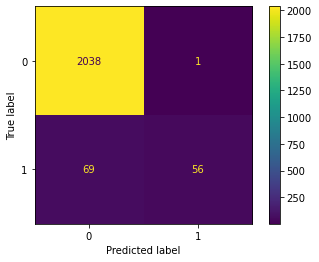

In [30]:
#plot_confusion_matrixのデフォルト設定でもプロットしてみる
#confusion_matrix関数と渡す引数がちがうことに注意
print('不均衡データ　ランダムフォレストモデルの混合行列')
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
plot_confusion_matrix(model_rf,test_x,test_y)

不均衡データ　ランダムフォレストモデルのROC曲線


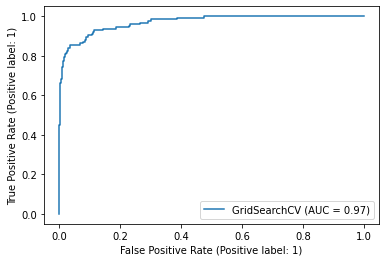

In [31]:
#plot_roc_curve関数によるROC曲線のプロット　引数は　モデル、test_x, test_y
print('不均衡データ　ランダムフォレストモデルのROC曲線')
from sklearn import metrics
rf_disp=metrics.plot_roc_curve(model_rf,test_x,test_y)  # treeのROC曲線
plt.show(rf_disp)  

# **不均衡データロジスティック回帰モデルによる予測モデル構築**

In [32]:
#ロジスティック回帰による分類
from sklearn.model_selection import cross_val_predict #交差検証
model_LR=LogisticRegression(class_weight='balanced',solver='liblinear')#ハイパーパラメーターをかっこ内に記述
pred_y=cross_val_predict(model_LR,test_x,test_y,cv=5) #cross validation の分割数を指定
model_LR.fit(train_x,train_y)

acc=accuracy_score(test_y,pred_y)
recall=recall_score(test_y,pred_y)
precision=precision_score(test_y,pred_y)
print('不均衡データ　ロジスティック回帰モデルの精度')
print('Accuracy:',acc)
print('Recall:',recall)
print('Precision:',precision)
conf_matrix=confusion_matrix(test_y,pred_y)
tn_LR,fp_LR,fn_LR,tp_LR=conf_matrix.ravel()
print('tn_LR,fp_LR,fn_LR,tp_LR=',tn_LR,fp_LR,fn_LR,tp_LR)
f_measure=f1_score(test_y,pred_y)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
g_mean=math.sqrt(sensitivity*specificity)
print('G_mean:{}'.format(g_mean))

不均衡データ　ロジスティック回帰モデルの精度
Accuracy: 0.833641404805915
Recall: 0.848
Precision: 0.2371364653243848
tn_LR,fp_LR,fn_LR,tp_LR= 1698 341 19 106
F-measure:0.3706293706293707
Sensitivity:0.848
Specificity:0.8327611574301128
G_mean:0.8403460367614853


不均衡データ　ロジスティック回帰モデルの精度


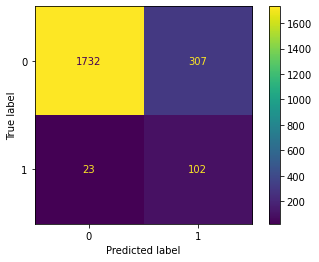

In [33]:
#plot_confusion_matrixのデフォルト設定でプロット
#confusion_matrix関数と渡す引数がちがうことに注意
print('不均衡データ　ロジスティック回帰モデルの精度')
plot_confusion_matrix(model_LR,test_x,test_y)

不均衡pデータ　ロジスティック回帰モデルの精度


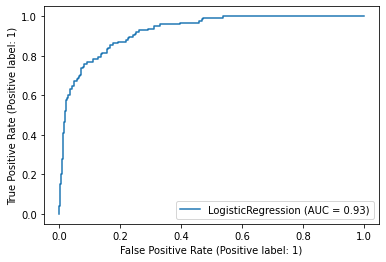

In [34]:
#plot_roc_curve関数によるROC曲線のプロット　引数は　モデル、test_x, 
print('不均衡pデータ　ロジスティック回帰モデルの精度')
LR_disp=metrics.plot_roc_curve(model_LR,test_x,test_y) 
ax = plt.gca()
plt.show()  

In [36]:
#あとでcategoricalデータはcatboostのデータセットを作成するときに別に指定します。
#categorical_data=['Gender_M',"DM",'Hyperlipidemia']
numerical_data=['rt_elbow_angle', 'rt_shoulder_angle',
       'rt_shoulder_Abduction', 'rt_hip_angle', 'rt_knee_angle',
       'lt_elbow_angle', 'lt_shoulder_angle', 'lt_shoulder_Abduction',
       'lt_hip_angle', 'lt_knee_angle', 'rtwrist_ratio', 'ltwrist_ratio',
       'rttrunksize', 'lttrunksuze']

#feat_cols=categorical_data+numerical_data
feat_cols=numerical_data
print(feat_cols)

['rt_elbow_angle', 'rt_shoulder_angle', 'rt_shoulder_Abduction', 'rt_hip_angle', 'rt_knee_angle', 'lt_elbow_angle', 'lt_shoulder_angle', 'lt_shoulder_Abduction', 'lt_hip_angle', 'lt_knee_angle', 'rtwrist_ratio', 'ltwrist_ratio', 'rttrunksize', 'lttrunksuze']


catboostでgridsearch 参考URL
https://data-analysis-stats.jp/python/python%e3%81%a7catboost%e3%81%ae%e8%a7%a3%e8%aa%ac/#:~:text=CatBoost%E3%81%AF%E3%80%81%E3%82%AA%E3%83%BC%E3%83%90%E3%83%BC%E3%83%95%E3%82%A3%E3%83%83%E3%83%88%E3%82%92%E6%B8%9B%E3%82%89%E3%81%97%E3%80%81%E3%83%87%E3%83%BC%E3%82%BF%E3%82%BB%E3%83%83%E3%83%88%E5%85%A8%E4%BD%93%E3%82%92%E3%83%88%E3%83%AC%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0%E3%81%AB%E4%BD%BF%E7%94%A8%E3%81%A7%E3%81%8D%E3%82%8B%E3%82%88%E3%81%86%E3%81%AB%E3%81%99%E3%82%8B%E3%80%81%E3%82%88%E3%82%8A%E5%8A%B9%E7%8E%87%E7%9A%84%E3%81%AA%E6%88%A6%E7%95%A5%E3%82%92%E4%BD%BF%E7%94%A8%E3%81%97%E3%81%BE%E3%81%99%E3%80%82,P%E3%81%8A%E3%82%88%E3%81%B3%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E3%83%BCa%3E%200%EF%BC%88%E4%BA%8B%E5%89%8D%E5%88%86%E5%B8%83%E3%81%AE%E9%87%8D%E3%81%BF%EF%BC%89%E3%80%82

In [39]:
import catboost as cb
from datetime import datetime
start_time = datetime.now()
# パラメータ調整
params = {'depth': [3, 5, 7],
'learning_rate' : [0.03, 0.1, 0.15],
'l2_leaf_reg': [1,3,7],
'iterations': [300]}
ctb = cb.CatBoostClassifier(eval_metric="AUC", logging_level='Silent')
model_cb = GridSearchCV(ctb, params, scoring="roc_auc", cv = 3, verbose=2)
model_cb.fit(train_x,train_y)
print(model_cb.best_params_)
print(model_cb.best_index_)
print(model_cb.best_score_)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

pred_y = model_cb.predict(test_x)

acc=accuracy_score(test_y,pred_y)
recall=recall_score(test_y,pred_y)
precision=precision_score(test_y,pred_y)
print('不均衡データ　catboostモデルの精度')
print('Accuracy:',acc)
print('Recall:',recall)
print('Precision:',precision)
conf_matrix=confusion_matrix(test_y,pred_y)
tn_CB,fp_CB,fn_CB,tp_CB=conf_matrix.ravel()
print('tn_CB,fp_CB,fn_CB,tp_CB=',tn_CB,fp_CB,fn_CB,tp_CB)
f_measure=f1_score(test_y,pred_y)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
g_mean=math.sqrt(sensitivity*specificity)
print('G_mean:{}'.format(g_mean))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.03; total time=   0.5s
[CV] END depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.03; total time=   0.5s
[CV] END depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.03; total time=   0.5s
[CV] END depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.1; total time=   0.5s
[CV] END depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.1; total time=   0.5s
[CV] END depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.1; total time=   0.5s
[CV] END depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.15; total time=   0.5s
[CV] END depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.15; total time=   0.5s
[CV] END depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.15; total time=   0.5s
[CV] END depth=3, iterations=300, l2_leaf_reg=3, learning_rate=0.03; total time=   0.5s
[CV] END depth=3, iterations=300, l2_leaf_reg=3, learning_rate

不均衡pデータ　CatBoost モデルの精度


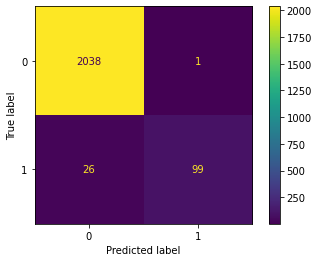

In [40]:
#Cat_Boostモデルの混合行列
#plot_confusion_matrixのデフォルト設定でプロット
#confusion_matrix関数と渡す引数がちがうことに注意
print('不均衡pデータ　CatBoost モデルの精度')
plot_confusion_matrix(model_cb,test_x,test_y)

不均衡データ　CatBoost モデルの精度


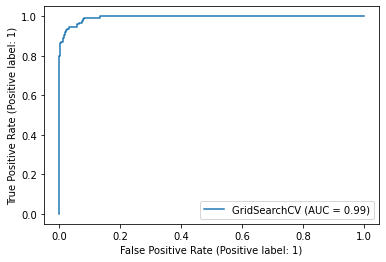

In [41]:
#Cat_BoostのROC曲線
print('不均衡データ　CatBoost モデルの精度')
Cat_disp=metrics.plot_roc_curve(model_cb,test_x,test_y)  # treeのROC曲線
plt.show(Cat_disp)  

# **不均衡データ AdaBoost モデルによる予測モデル構築**

In [42]:
#不均衡データに強いとされるAdaBoostでグリッドサーチしてみる
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
n_estimators = [100,200,300,400];
score='recall'#モデルの評価関数を指定 roc_aucからrecallに変更
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)
learning_r = [0.1,1,0.01]

parameters = {'n_estimators':n_estimators,
              'learning_rate':learning_r
              
        }
Ada_Boost_CV = GridSearchCV(AdaBoostClassifier(base_estimator= None, ## If None, then the base estimator is a decision tree.
                                     ),
                                 param_grid=parameters,
                                 cv=cv,
                                 scoring=score,
                                 n_jobs = -1)
Ada_Boost_CV.fit(train_x,train_y) 
print('不均衡データ　AdaBoostモデルの精度')
print(Ada_Boost_CV.best_params_)
pred_y=Ada_Boost_CV.predict(test_x)#予測値の算出
train_accuracy=Ada_Boost_CV.score(train_x,train_y)#学習データでの精度の算出
print('Train Accuracy:{}'.format(train_accuracy))
test_accuracy=accuracy_score(test_y,pred_y)#テストデータでの精度の算出
print('Test Accuracy:{}'.format(test_accuracy))
recall=recall_score(test_y,pred_y)
print('Recall:{}'.format(recall))
precision=precision_score(test_y,pred_y)
print('Precision:{}'.format(precision))
f_measure=f1_score(test_y,pred_y)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
#不均衡モデルの評価に感度と特異度の相乗平均g_meanを計算
g_mean=math.sqrt(sensitivity*specificity)
print('G_mean:{}'.format(g_mean))

不均衡データ　AdaBoostモデルの精度
{'learning_rate': 1, 'n_estimators': 400}
Train Accuracy:0.9417808219178082
Test Accuracy:0.9718114602587801
Recall:0.656
Precision:0.82
F-measure:0.7288888888888888
Sensitivity:0.656
Specificity:0.9911721432074546
G_mean:0.8063553347898743


不均衡pデータ　AdaBoost モデルの精度


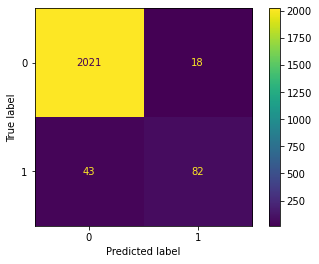

In [43]:
#Ada_Boostモデルの混合行列
#plot_confusion_matrixのデフォルト設定でプロット
#confusion_matrix関数と渡す引数がちがうことに注意
print('不均衡pデータ　AdaBoost モデルの精度')
plot_confusion_matrix(Ada_Boost_CV,test_x,test_y)

不均衡データ　AdaBoost モデルの精度


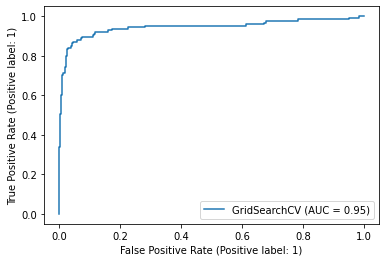

In [44]:
#Ada_BoostのROC曲線
print('不均衡データ　AdaBoost モデルの精度')
Ada_disp=metrics.plot_roc_curve(Ada_Boost_CV,test_x,test_y)  # treeのROC曲線
plt.show(Ada_disp)  

# **不均衡データlight GBM モデルによる予測モデル構築**

In [45]:
#LightGBM scikit learn APIによる訓練 confusion matrix関数を使うにはsk-learn APIが必要

model_lgb = lgb.LGBMClassifier(objective='binary',
                        metric='binary_error',#AUCからbinary_errorに変更　https://testlightgbm.readthedocs.io/en/latest/Parameters.html#
                        n_estimators=1000,
                        early_stopping_rounds=100)
model_lgb.fit(train_x,train_y,#scilit learn APIではfitで訓練データを渡す original APIではtrain 
        eval_set=[(test_x, test_y)],
        verbose=50)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's binary_error: 0.0152495
[100]	valid_0's binary_error: 0.0124769
[150]	valid_0's binary_error: 0.0120148
Early stopping, best iteration is:
[98]	valid_0's binary_error: 0.0120148


LGBMClassifier(early_stopping_rounds=100, metric='binary_error',
               n_estimators=1000, objective='binary')

In [46]:
pred_y=model_lgb.predict(test_x)
acc=accuracy_score(test_y,pred_y)
recall=recall_score(test_y,pred_y)
precision=precision_score(test_y,pred_y)
f_measure=f1_score(test_y,pred_y)
print('Accuracy:',acc)
print('Recall:',recall)
print('Precision:',precision)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
conf_matrix=confusion_matrix(test_y,pred_y)
tn,fp,fn,tp=conf_matrix.ravel()
print('tn,fp,fn,tp=',tn,fp,fn,tp)
#不均衡モデルの評価に感度と特異度の相乗平均g_meanを計算
g_mean=math.sqrt(sensitivity*specificity)
print('G_mean:{}'.format(g_mean))

Accuracy: 0.987985212569316
Recall: 0.792
Precision: 1.0
F-measure:0.8839285714285714
Sensitivity:0.792
Specificity:1.0
tn,fp,fn,tp= 2039 0 26 99
G_mean:0.8899438184514796


不均衡データ　light GBM モデルの精度


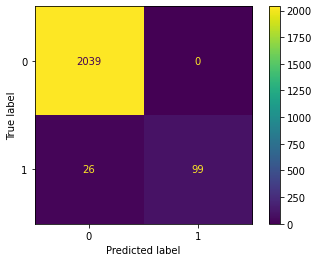

In [48]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
print('不均衡データ　light GBM モデルの精度')
plot_confusion_matrix(model_lgb,test_x,test_y)

不均衡データ　lightGBM モデルの精度


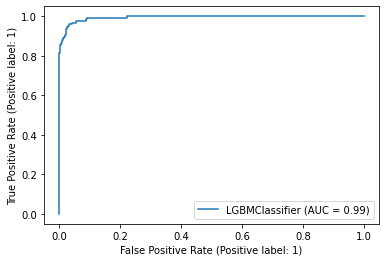

In [49]:
print('不均衡データ　lightGBM モデルの精度')
lgb_disp=metrics.plot_roc_curve(model_lgb,test_x,test_y)  # LGBMClassigier modelのROC曲線
plt.show()   

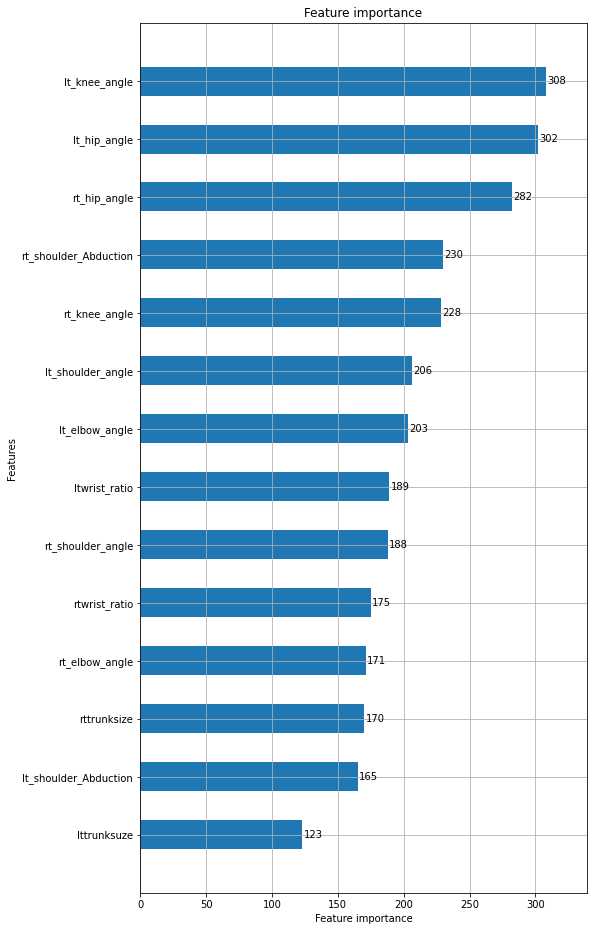

In [50]:
lgb.plot_importance(model_lgb,height=0.5,figsize=(8,16), importance_type='split')

# **oversamplingを行ってデータの不均衡をなくす


In [51]:
#imbalanced-learnでデータの不均衡に対応
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
print(imblearn.__version__)

0.8.1


 公式ドキュメントでは先にtrain_test_splitしており、testデータではSMOTEしていない kaggleのこの記事参照　 https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets 
 testデータにはoversamplingしたデータは使わない　leakが生じるため
ほかに色々試しているkaggleのnotebook https://www.kaggle.com/andreanuzzo/balance-the-imbalanced-rf-and-xgboost-with-smote

In [52]:
#テストデータの’１’の数のカウント
positive_count_test =test_y.sum()
print('positive count test: {}'.format(positive_count_test))

positive count test: 125


In [53]:
#訓練データのみに対してSMOTEによる水増し
smote = SMOTE(random_state=42)
x_SMOTE, y_SMOTE = smote.fit_resample(train_x,train_y)
print('positive count before oversampling(SMOTE)',train_y.sum())
print('positive count after oversampling(SMOTE)',y_SMOTE.sum())

positive count before oversampling(SMOTE) 292
positive count after oversampling(SMOTE) 4755


# **OverSampling dataにたいしてRandom Forestにてモデル作成**

In [54]:
#ランダムフォレストモデルの構築
gridsearch = {'n_estimators': [100,200,300,400],#決定木の数を辞書で渡す
             'max_depth': [4,5,6]}#決定木の数を辞書で渡す
score='recall'#モデルの評価関数を指定https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
              #今回はrecall
smote_model_rf=GridSearchCV(RandomForestClassifier(),#分類器の指定
                 gridsearch,#グリッドサーチで定義した辞書を渡す
                 cv=5,              #交差検定の回数指定
                 n_jobs= -1, #-1に設定するとコア数で並列実行
                 scoring=score,#モデルの評価関数の指定 今回は異常検知なのでrecall使用
                 verbose=True) #verbose=Trueで実行状況の表示
smote_model_rf.fit(x_SMOTE,y_SMOTE)#学習の実行 fit関数
pred_y=smote_model_rf.predict(test_x)#予測値の算出
train_accuracysmote_=model_rf.score(x_SMOTE,y_SMOTE)#学習データでの精度の算出
print('Oversamplingデータ　ランダムフォレスト モデルの精度')
print('Train Accuracy:{}'.format(train_accuracy))
test_accuracy=accuracy_score(test_y,pred_y)#テストデータでの精度の算出
print('Test Accuracy:{}'.format(test_accuracy))
recall=recall_score(test_y,pred_y)
print('Recall:{}'.format(recall))
precision=precision_score(test_y,pred_y)
print('Precision:{}'.format(precision))
f_measure=f1_score(test_y,pred_y)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
#不均衡モデルの評価に感度と特異度の相乗平均g_meanを計算
g_mean=math.sqrt(sensitivity*specificity)
print('G_mean:{}'.format(g_mean))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Oversamplingデータ　ランダムフォレスト モデルの精度
Train Accuracy:0.9417808219178082
Test Accuracy:0.9487060998151571
Recall:0.904
Precision:0.5330188679245284
F-measure:0.6706231454005935
Sensitivity:0.904
Specificity:0.9514467876410004
G_mean:0.927420021364357


In [55]:
smote_model_rf.best_estimator_

RandomForestClassifier(max_depth=6, n_estimators=300)

Oversamplingデータ　ランダムフォレスト モデルの精度


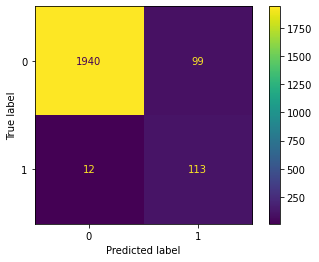

In [56]:
#plot_confusion_matrixのデフォルト設定でプロット
#confusion_matrix関数と渡す引数がちがうことに注意
print('Oversamplingデータ　ランダムフォレスト モデルの精度')
plot_confusion_matrix(smote_model_rf,test_x,test_y)

Oversamplingデータ　ランダムフォレスト モデルの精度


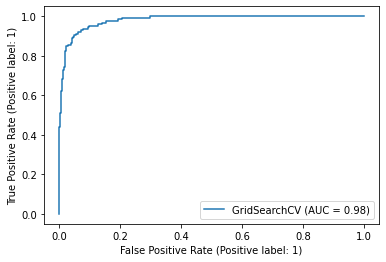

In [57]:
#plot_roc_curve関数によるROC曲線のプロット　引数は　モデル、test_x, test_y
print('Oversamplingデータ　ランダムフォレスト モデルの精度')
from sklearn import metrics
smote_rf_disp=metrics.plot_roc_curve(smote_model_rf,test_x,test_y)  # treeのROC曲線
plt.show(smote_rf_disp)  

# **OverSampling dataにたいしてロジステック回帰にてモデル作成**

In [58]:
#ロジスティック回帰による分類
from sklearn.model_selection import cross_val_predict #交差検証
smote_model_LR=LogisticRegression(class_weight='balanced',solver='liblinear')#ハイパーパラメーターをかっこ内に記述
pred_y=cross_val_predict(smote_model_LR,test_x,test_y,cv=5) #cross validation の分割数を指定
smote_model_LR.fit(x_SMOTE,y_SMOTE)

acc=accuracy_score(test_y,pred_y)
recall=recall_score(test_y,pred_y)
precision=precision_score(test_y,pred_y)
print('Oversamplingデータ　ロジステック回帰 モデルの精度')
print('Accuracy:',acc)
print('Recall:',recall)
print('Precision:',precision)
conf_matrix=confusion_matrix(test_y,pred_y)
tn_LR,fp_LR,fn_LR,tp_LR=conf_matrix.ravel()
print('tn_LR,fp_LR,fn_LR,tp_LR=',tn_LR,fp_LR,fn_LR,tp_LR)
f_measure=f1_score(test_y,pred_y)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
#不均衡モデルの評価に感度と特異度の相乗平均g_meanを計算
g_mean=math.sqrt(sensitivity*specificity)
print('G_mean:{}'.format(g_mean))

Oversamplingデータ　ロジステック回帰 モデルの精度
Accuracy: 0.833641404805915
Recall: 0.848
Precision: 0.2371364653243848
tn_LR,fp_LR,fn_LR,tp_LR= 1698 341 19 106
F-measure:0.3706293706293707
Sensitivity:0.848
Specificity:0.8327611574301128
G_mean:0.8403460367614853


Oversamplingデータ　ロジステック回帰 モデルの精度


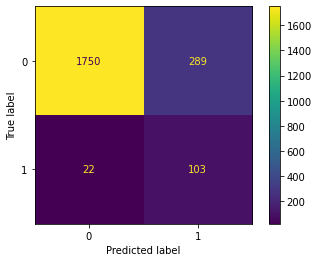

In [59]:
#plot_confusion_matrixのデフォルト設定でプロット
#confusion_matrix関数と渡す引数がちがうことに注意
print('Oversamplingデータ　ロジステック回帰 モデルの精度')
plot_confusion_matrix(smote_model_LR,test_x,test_y)

Oversamplingデータ　ロジステック回帰 モデルの精度


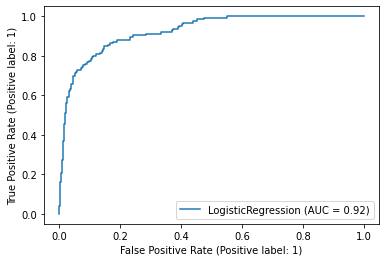

In [60]:
#plot_roc_curve関数によるROC曲線のプロット　引数は　モデル、test_x, test_y
print('Oversamplingデータ　ロジステック回帰 モデルの精度')
smote_LR_disp=metrics.plot_roc_curve(smote_model_LR,test_x,test_y)  
ax = plt.gca()
plt.show()  

# **Oversampling（SMOTE）にたいしてCatboostでのモデル構築**

In [61]:
start_time = datetime.now()
# パラメータ調整
params = {'depth': [3, 5, 7],
'learning_rate' : [0.03, 0.1, 0.15],
'l2_leaf_reg': [1,3,7],
'iterations': [300]}
ctb = cb.CatBoostClassifier(eval_metric="AUC", logging_level='Silent')
model_cb = GridSearchCV(ctb, params, scoring="roc_auc", cv = 3, verbose=2)
model_cb.fit(x_SMOTE,y_SMOTE)
print(model_cb.best_params_)
print(model_cb.best_index_)
print(model_cb.best_score_)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

pred_y = model_cb.predict(test_x)

acc=accuracy_score(test_y,pred_y)
recall=recall_score(test_y,pred_y)
precision=precision_score(test_y,pred_y)
print('SMOTE　catboostモデルの精度')
print('Accuracy:',acc)
print('Recall:',recall)
print('Precision:',precision)
conf_matrix=confusion_matrix(test_y,pred_y)
tn_CB,fp_CB,fn_CB,tp_CB=conf_matrix.ravel()
print('tn_CB,fp_CB,fn_CB,tp_CB=',tn_CB,fp_CB,fn_CB,tp_CB)
f_measure=f1_score(test_y,pred_y)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
g_mean=math.sqrt(sensitivity*specificity)
print('G_mean:{}'.format(g_mean))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.03; total time=   0.7s
[CV] END depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.03; total time=   0.7s
[CV] END depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.03; total time=   0.7s
[CV] END depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.1; total time=   0.6s
[CV] END depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.1; total time=   0.6s
[CV] END depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.1; total time=   0.6s
[CV] END depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.15; total time=   0.6s
[CV] END depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.15; total time=   0.7s
[CV] END depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.15; total time=   0.7s
[CV] END depth=3, iterations=300, l2_leaf_reg=3, learning_rate=0.03; total time=   0.7s
[CV] END depth=3, iterations=300, l2_leaf_reg=3, learning_rate

不均衡pデータ　CatBoost モデルの精度


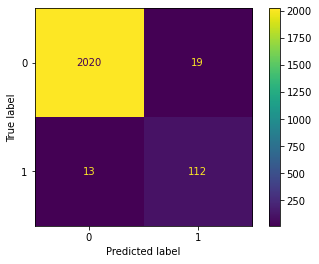

In [62]:
#Cat_Boostモデルの混合行列
#plot_confusion_matrixのデフォルト設定でプロット
#confusion_matrix関数と渡す引数がちがうことに注意
print('不均衡pデータ　CatBoost モデルの精度')
plot_confusion_matrix(model_cb,test_x,test_y)

SMOTデータ　CatBoost モデルの精度


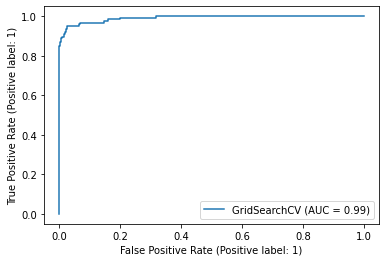

In [63]:
#Cat_BoostのROC曲線
print('SMOTデータ　CatBoost モデルの精度')
Cat_disp=metrics.plot_roc_curve(model_cb,test_x,test_y)  # treeのROC曲線
plt.show(Cat_disp)  

# **Oversampling（SMOTE）にたいしてAdaboostでのモデル構築**

In [64]:
#AdaBoostによるSMOTEデータに対する訓練と分類
#AdaBoostでグリッドサーチしてみる
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
n_estimators = [100,200,300,400];
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)
learning_r = [0.1,1,0.01]
score='recall'#モデルの評価関数を指定 roc_aucからrecallに変更

parameters = {'n_estimators':n_estimators,
              'learning_rate':learning_r
              
        }
smote_Ada_Boost_CV = GridSearchCV(AdaBoostClassifier(base_estimator= None, ## If None, then the base estimator is a decision tree.
                                     ),
                                 param_grid=parameters,
                                 cv=cv,
                                 scoring=score,
                                 n_jobs = -1)
smote_Ada_Boost_CV.fit(x_SMOTE,y_SMOTE) 
print(smote_Ada_Boost_CV.best_params_)
pred_y=smote_Ada_Boost_CV.predict(test_x)#予測値の算出
train_accuracy=smote_Ada_Boost_CV.score(x_SMOTE,y_SMOTE)#学習データでの精度の算出

print('Oversamplingデータ　AdaBoost モデルの精度')
print('Train Accuracy:{}'.format(train_accuracy))
test_accuracy=accuracy_score(test_y,pred_y)#テストデータでの精度の算出
print('Test Accuracy:{}'.format(test_accuracy))
recall=recall_score(test_y,pred_y)
print('Recall:{}'.format(recall))
precision=precision_score(test_y,pred_y)
print('Precision:{}'.format(precision))
f_measure=f1_score(test_y,pred_y)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
#不均衡モデルの評価に感度と特異度の相乗平均g_meanを計算
g_mean=math.sqrt(sensitivity*specificity)
print('G_mean:{}'.format(g_mean))

{'learning_rate': 1, 'n_estimators': 400}
Oversamplingデータ　AdaBoost モデルの精度
Train Accuracy:0.9819137749737119
Test Accuracy:0.9473197781885397
Recall:0.84
Precision:0.5276381909547738
F-measure:0.6481481481481481
Sensitivity:0.84
Specificity:0.9538989700833742
G_mean:0.8951397292434485


Oversamplingデータ　AdaBoost モデルの精度


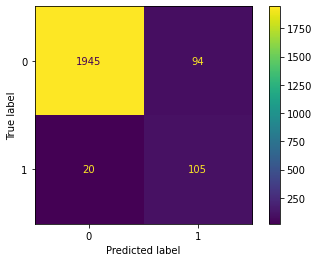

In [65]:
#Ada_Boostモデルの混合行列
#plot_confusion_matrixのデフォルト設定でプロット
#confusion_matrix関数と渡す引数がちがうことに注意
print('Oversamplingデータ　AdaBoost モデルの精度')
plot_confusion_matrix(smote_Ada_Boost_CV,test_x,test_y)

Oversamplingデータ　AdaBoost モデルの精度


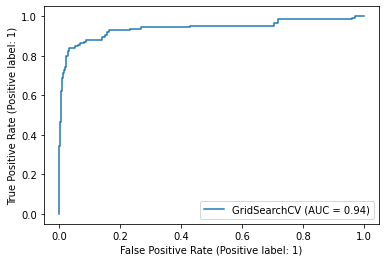

In [66]:
#Ada_BoostのROC曲線
print('Oversamplingデータ　AdaBoost モデルの精度')
smote_Ada_disp=metrics.plot_roc_curve(smote_Ada_Boost_CV,test_x,test_y)  
plt.show(smote_Ada_disp)  

# **Oversampling（SMOTE）に対してのLightGBM によるモデル構築**

In [67]:
#LightGBM scikit learn APIによる訓練 confusion matrix関数を使うにはsk-learn APIが必要

smote_model_lgb = lgb.LGBMClassifier(objective='binary',
                        metric='binary_error',
                        n_estimators=1000,
                        early_stopping_rounds=100)
smote_model_lgb.fit(x_SMOTE,y_SMOTE,#scilit learn APIではfitで訓練データを渡す original APIではtrain 
        eval_set=[(test_x, test_y)],
        verbose=50)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's binary_error: 0.0194085
[100]	valid_0's binary_error: 0.0143253
[150]	valid_0's binary_error: 0.012939
[200]	valid_0's binary_error: 0.0124769
[250]	valid_0's binary_error: 0.0134011
Early stopping, best iteration is:
[160]	valid_0's binary_error: 0.0115527


LGBMClassifier(early_stopping_rounds=100, metric='binary_error',
               n_estimators=1000, objective='binary')

Oversamplingデータ　LightGBM モデルの精度


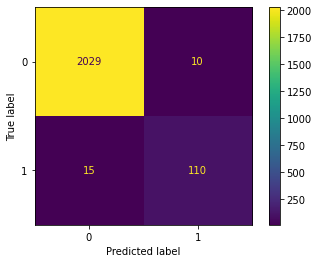

In [68]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
print('Oversamplingデータ　LightGBM モデルの精度')
plot_confusion_matrix(smote_model_lgb,test_x,test_y)

In [69]:
pred_y=smote_model_lgb.predict(test_x)
acc=accuracy_score(test_y,pred_y)
recall=recall_score(test_y,pred_y)
precision=precision_score(test_y,pred_y)
f_measure=f1_score(test_y,pred_y)

print('Oversamplingデータ　LightGBM モデルの精度')
print('Accuracy:',acc)
print('Recall:',recall)
print('Precision:',precision)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
conf_matrix=confusion_matrix(test_y,pred_y)
tn,fp,fn,tp=conf_matrix.ravel()
print('tn,fp,fn,tp=',tn,fp,fn,tp)
#不均衡モデルの評価に感度と特異度の相乗平均g_meanを計算
g_mean=math.sqrt(sensitivity*specificity)
print('G_mean:{}'.format(g_mean))

Oversamplingデータ　LightGBM モデルの精度
Accuracy: 0.9884473197781886
Recall: 0.88
Precision: 0.9166666666666666
F-measure:0.8979591836734694
Sensitivity:0.88
Specificity:0.9950956351152526
tn,fp,fn,tp= 2029 10 15 110
G_mean:0.9357799735522353


Oversamplingデータ　LightGBM モデルの精度


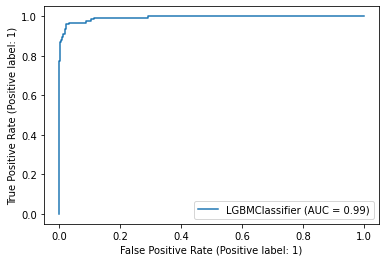

In [70]:
print('Oversamplingデータ　LightGBM モデルの精度')
smote_lgb_disp=metrics.plot_roc_curve(smote_model_lgb,test_x,test_y)  # LGBMClassigier model2のROC曲線
plt.show()   

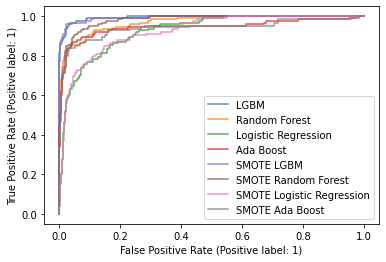

In [71]:
#いままでのROC曲線をまとめて表示
ax = plt.gca()
lgb_disp.plot(ax=ax, alpha=0.8,label='LGBM')
rf_disp.plot(ax=ax,alpha=0.8,label='Random Forest')
LR_disp.plot(ax=ax,alpha=0.8,label='Logistic Regression')
Ada_disp.plot(ax=ax,alpha=0.8,label='Ada Boost')

smote_lgb_disp.plot(ax=ax, alpha=0.8,label='SMOTE LGBM')
smote_rf_disp.plot(ax=ax,alpha=0.8,label='SMOTE Random Forest')
smote_LR_disp.plot(ax=ax,alpha=0.8,label='SMOTE Logistic Regression')
smote_Ada_disp.plot(ax=ax,alpha=0.8,label='SMOTE Ada Boost')

plt.show()

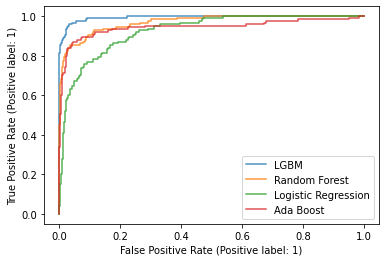

In [72]:
#いままでのROC曲線をまとめて表示(SMOTEの成績が悪かったのでSMOTEしていないものを表示)
ax = plt.gca()
lgb_disp.plot(ax=ax, alpha=0.8,label='LGBM')
rf_disp.plot(ax=ax,alpha=0.8,label='Random Forest')
LR_disp.plot(ax=ax,alpha=0.8,label='Logistic Regression')
Ada_disp.plot(ax=ax,alpha=0.8,label='Ada Boost')
plt.show()

In [73]:
#LGBMモデルがベストモデルであったのでそれをpickleで保存する
import pickle
file = 'trained_lgb_model_20221119.pkl'
pickle.dump(model_lgb, open(file, 'wb'))

In [74]:
#モデルが読み込めるか確認
#pickleを使ってモデルを読み込み
model = pickle.load(open('trained_lgb_model_20221119.pkl', 'rb'))
model

LGBMClassifier(early_stopping_rounds=100, metric='binary_error',
               n_estimators=1000, objective='binary')